# DEA-LaserCom research notebook

## ILD1320 sensor interface

See the [operation manual](https://www.micro-epsilon.com/download/manuals/man--optoNCDT-1320--en.pdf) for this sensor for the references cited throughout this document.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

Let's first install [pySerial](https://pythonhosted.org/pyserial/pyserial.html).

In [2]:
try:
    import serial
except:
    import sys
    !{sys.executable} -m pip install pyserial --user
    import serial

This class gives us an interface for working with bidirectional streams.

In [3]:
class StreamInterface:
    def __init__(self, stream, encoding, eol):
        self.stream = stream
        self.encoding = encoding
        self.eol = eol.encode(self.encoding)
        
    def write(self, message, return_response=False):
        self.stream.write(message.encode(self.encoding) + self.eol)
        if return_response:
            if isinstance(return_response, int): return self.stream.read(return_response)
            else: return self.stream.readlines()
        else: return None

To communicate with the ILD1320 sensor, we are using 8 data bits and no stop bits. The data are sent from the sensor as three-byte packets, low-to-high:

|         |   |   |   |   |   |   |   |   |   |
|---------|---|---|---|---|---|---|---|---|---|
| $L$-Byte | $0$ | $0$ || $D5$ | $D4$ | $D3$ | $D2$ | $D1$ | $D0$ |
| $M$-Byte | $0$ | $1$ || $D11$ | $D10$ | $D9$ | $D8$ | $D7$ | $D6$ |
| $H$-Byte | $1$ | $0$ || $(D^*)$ | $(D17)$ | $(D16)$ | $D15 $| $D14$ | $D13$ |

The $D$-bits are put together in decreasing order of index (big-endian). Every observation cycle, each output parameter is individually sent in such a three-byte block, with effective data width between 16 and 18 bits ($D0$ - $D16, D18$). Since multiple output parameters can be chosen via `OUTADD_RS422` (Appendix A 3.5.3.2) for each observation cycle, bit $D^*$ is $0$ when the current three-byte block is the first in its observation cycle.
See section 7.2.2 of the [operation manual](https://www.micro-epsilon.com/download/manuals/man--optoNCDT-1320--en.pdf) for more details on the encoding scheme.

Using the formula provided in section 7.2.2, we can calculate the distance in millimeters. The `observe` function returns the $x$ in that expression. Measuring range is given in millimeters.

In [4]:
class ILD1320(StreamInterface):
    def __init__(self, stream, encoding='ascii', eol='\r\n', **kwargs):
        super().__init__(stream, encoding, eol)
        self.__dict__.update({
            "measuring_range": 100,
            "start_of_measuring_range": 50
        })
        self.__dict__.update(kwargs)
    
    def observe(self):
        while True: # until we get the first low-order byte
            l = int.from_bytes(self.stream.read(1), byteorder="big")
            #print(format(l, '#010b'))
            if ((l >> 6) != 0): continue
        
            m = int.from_bytes(self.stream.read(1), byteorder="big")
            #print(format(m, '#010b'))
            if ((m >> 6) != 1): continue
            
            h = int.from_bytes(self.stream.read(1), byteorder="big")
            #print(format(h, '#010b'))
            if ((h >> 6) != 2): continue
        
            # currently inelegant solution to buffer problem
            self.stream.reset_input_buffer()
            return ((h & 0x3f) << 12) | ((m & 0x3f) << 6) | (l & 0x3f)
    
    def distance(self, sleep=0):
        if sleep > 0: time.sleep(sleep)
        return ((1/100)*(((102*self.observe())/65520)-1)*self.measuring_range) + self.start_of_measuring_range

By using the `by-id` directory, which simlinks info `/dev/tty`, you can reference the serial device by its unique ID.

In [5]:
ild1320_stream = serial.Serial(
    '/dev/serial/by-id/usb-Micro-Epsilon_Micro-Epsilon_IF2001_USB_002988-if00-port0', 
    baudrate=921000, timeout=0
)

ild1320 = ILD1320(ild1320_stream)

Mastering is disabled until I can create an object-oriented implementation. We probably don't need it for our measurements, anyway.

In [6]:
for command in ['TRIGGER NONE', 'OUTHOLD NONE', 'MEASPEAK DISTA', 'MEASRATE 2', 
                'OUTPUT RS422', 'ECHO OFF', 'MASTERMV NONE', 'LASERPOW FULL']:
    ild1320.write(command)

Using the formula provided in section 7.2.2, we can calculate the distance in millimeters. The function above returns the `x` in that expression. Measuring range is given in millimeters.

Here's an infinite loop (with updating) to show raw distances from the sensor.

In [7]:
def ild1320_continuous_measurement():
    try:
        while True:
            clear_output(wait=True)
            print(round(ild1320.distance(), 2))
            print(ild1320.stream.in_waiting)
            time.sleep(0.09)
    except KeyboardInterrupt:
        clear_output(wait=True)
        
ild1320_continuous_measurement()

106.23
0


Now we integrate the with the ESP32 microcontroller that controls PWM voltage output to the actuator.

## Dielectric elastomer actuator remote interface

In [8]:
class DEAController(StreamInterface):
    def __init__(self, stream, encoding='ascii', eol='', **kwargs):
        super().__init__(stream, encoding, eol)
        
        self.frmt = "A{aDuty:.2f}B{bDuty:.2f}C{cDuty:.2f}D{dDuty:.2f}"
        
    def pwm(self, i):
        if (i >= 0):
            self.write(self.frmt.format(aDuty=0, bDuty=i, cDuty=i, dDuty=0))
        else:
            self.write(self.frmt.format(aDuty=abs(i), bDuty=0, cDuty=0, dDuty=abs(i)))
            
    def quadrant_pwm(self, a, b, c, d):
        self.write(self.frmt.format(aDuty=abs(a), bDuty=abs(b), cDuty=abs(c), dDuty = abs(b)))

In [9]:
dea_stream = serial.Serial(
    '/dev/serial/by-id/usb-Silicon_Labs_CP2102N_USB_to_UART_Bridge_Controller_e22272fd3499e8119165bc20c3e5cfbd-if00-port0', 
    baudrate=115200, timeout=0
)

dea = DEAController(dea_stream)

We address the microcontroller with a string encoding a floating-point number that gives the desired duty cycle from `full_duty_voltage` kV. We need two archetypal loops: an inner loop for measuring elastomer displacement every `sample_intr` seconds, up to `rest_intr` seconds, with a constant duty cycle; and an outer loop for adjusting the duty cycle every `rest_intr` seconds and maintaining continuous sampling throughout by calling the inner loop.

Note that sampling happens essentially continuously, every `sample_intr` seconds. So time is kept discrete, but it can be easily calculated from the parameters above.

In [10]:
import csv
import functools
from datetime import datetime

class DEATester:
    def __init__(self, dea, sensor, intervals={}):
        self.dea = dea
        self.sensor = sensor
        self.intervals = intervals
        self.figsize = (7, 5)
        self.seconds_left = 0
        self.reset()
        
    def reset(self):
        self.xs = []
        self.ys = []
        self.seconds_left = 0

    def measure_loop(self, rest=None):
        clear_output(wait=True)
        if rest is None: rest = self.pwm_range[0]
        samples = int(self.intervals['hold']/self.intervals['sample'])
        self.dea.pwm(rest)
        for i in range(samples):
            print("duty cycle: {}\nsamples: {} / {}".format(rest, i + 1, samples))
            dist = round(self.sensor.distance(), 4)
            if dist == 456.9938:
                raise ValueError("Sensor entered error state")
                
            print("observation: {} mm".format(dist))
            tester.ys.append(dist)
            tester.xs.append(rest)
            time.sleep(self.intervals['sample'])
            clear_output(wait=True)
            
    def increment_loop(self, range=[0., 100], reverse=False):
        pwm_range = np.arange(*range, -self.intervals['pwm'] if reverse else self.intervals['pwm'])
        self.seconds_left = 0
        for pwm in pwm_range:
            if self.intervals['hold'] > 0: 
                self.measure_loop(pwm)
                
            clear_output(wait=True)
            if self.intervals['rest'] > 0:
                self.dea.pwm(0)
                print("resting: {} duty cycle, {} sec".format(0, self.intervals['rest']))
                time.sleep(self.intervals['rest'])
                

    def export(self, prefix="data"):
        with open(
            "{}-{}-{}-{}-{}-{}.csv".format(
                prefix,
                time.strftime("%Y%m%d-%H%M%S"),
                *[interval for interval in self.intervals.values()]
            ), 'w') as csvfile:
            wr = csv.writer(csvfile)
            for x, y in zip(self.xs, self.ys):
                wr.writerow([x, y])
                
    def to_df(self):
        return pd.DataFrame({"t": range(len(self.xs)), "d": self.ys, "v": self.xs})

tester = DEATester(dea, ild1320)

Now we cycle actuation up and down, with measurement at the extremes to account for viscoelasticity. This also helps break in a new elastomer.

In [11]:
try:
    for t in range(20):
        dea.pwm(100)
        time.sleep(1)
        dea.pwm(-100)
        time.sleep(1)
except:
    dea.pwm(0)
    
dea.pwm(0)

Now we can use the full tester interface.

In [12]:
tester.intervals = {
    "sample": 0.1,
    "rest": 0,
    "hold": 1,
    "pwm": 5
}

tester.reset()
loops = 1
try:
    for loop in range(loops):
        tester.increment_loop([-70., 105.])
        tester.increment_loop([100., -70.], reverse=True)
except KeyboardInterrupt:
    tester.dea.pwm(0)
except:
    tester.dea.pwm(0)
    raise
    
dea.pwm(0)

duty cycle: -65.0
samples: 10 / 10
observation: 99.3026 mm


Using quadrant-based acutation, we can also just make the elastomer ride in a circle:

In [13]:
delay = 0.5
for i in range(10):
    dea.quadrant_pwm(99.0, 0.0, 0.0, 0.0)
    time.sleep(delay)
    dea.quadrant_pwm(0.0, 0.0, 0.0, 0.0)
    time.sleep(delay)
    dea.quadrant_pwm(0.0, 99.0, 0.0, 0.0)
    time.sleep(delay)
    dea.quadrant_pwm(0.0, 0.0, 0.0, 0.0)
    time.sleep(delay)
    dea.quadrant_pwm(0.0, 0.0, 99.0, 0.0)
    time.sleep(delay)
    dea.quadrant_pwm(0.0, 0.0, 0.0, 0.0)
    time.sleep(delay)
    dea.quadrant_pwm(0.0, 0.0, 0.0, 99.0)
    time.sleep(delay)
    dea.quadrant_pwm(0.0, 0.0, 0.0, 0.0)
    time.sleep(delay)

KeyboardInterrupt: 

If we are keeping duty cycle constant, we can just plot displacement against time:

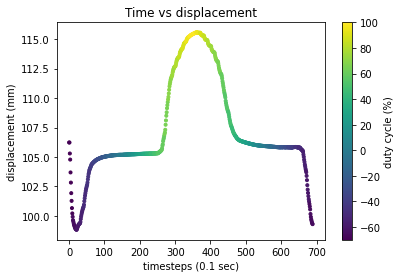

In [15]:
plt.scatter(range(len(tester.ys)), tester.ys, c=tester.xs, marker='.');
plt.title("Time vs displacement");
plt.colorbar(label="duty cycle (%)");
plt.xlabel("timesteps ({} sec)".format(tester.intervals['sample']));
plt.ylabel("displacement (mm)");

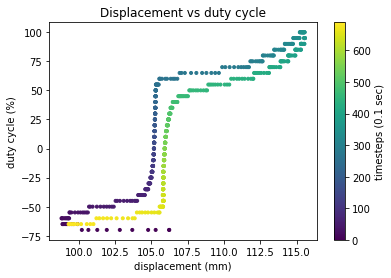

In [16]:
plt.scatter(tester.ys, tester.xs, c=range(len(tester.ys)), marker='.');
plt.title("Displacement vs duty cycle");
plt.colorbar(label="timesteps ({} sec)".format(tester.intervals['sample']));
plt.ylabel("duty cycle (%)");
plt.xlabel("displacement (mm)");

With the data from a full test, we can generate a 3D plot of time versus voltage versus displacement to see viscoelasticity in action.

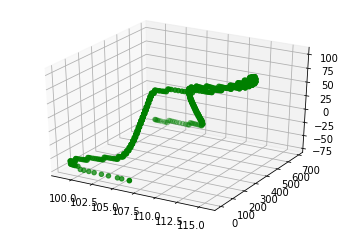

In [17]:
%matplotlib inline
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.scatter3D(tester.ys, range(len(tester.ys)), tester.xs, c='g', cmap='Greens');

## Machine learning adventures

### Basic polynomial fitting

We wish to model a function $d(v, t)$ that gives voltage as a function of time and desired displacement. We will follow the path described in "Deep Reinforcement Learning in Soft Viscoelastic Elastomer" (Li et al, 2019). The authors fit a 4-th order polynomial $v = P_t(d)$ to voltage-displacement pairs at each given point in time.

To obtain this data, we will first gather data on 5% voltage steps for 15 seconds, with a 10 second rest period in between each actuation.

In [18]:
intervals = {
    "sample": 0.1,
    "rest": 10,
    "hold": 45,
    "pwm": 5
}

In [19]:
tester.intervals = intervals

tester.reset()
loops = 1
try:
    for loop in range(loops):
        tester.increment_loop([40., 105.])
        
    tester.export()
except KeyboardInterrupt:
    tester.dea.pwm(0)
except:
    tester.dea.pwm(0)
    raise

dea.pwm(0)

resting: 0 duty cycle, 10 sec


Let's examine the difference between taking a break and not taking a break:

In [20]:
df_break = pd.read_csv("~/research/nathanael-ml/datafiles/data-20200808-104138-0.1-10-45-5.csv", names=['v', 'd'])
df_break['t'] = df_break.index

df_no_break = pd.read_csv("~/research/nathanael-ml/datafiles/data-20200808-104138-0.1-10-45-5.csv", names=['v', 'd'])
df_no_break['t'] = df_no_break.index

plt.scatter(df_no_break.t, df_no_break.d)
plt.scatter(df_break.t, df_break.d)

FileNotFoundError: [Errno 2] File /home/carson/research/nathanael-ml/datafiles/data-20200808-104138-0.1-10-45-5.csv does not exist: '/home/carson/research/nathanael-ml/datafiles/data-20200808-104138-0.1-10-45-5.csv'

It is also possible to import data directly from the CSV that we wisely created above. Note that the timestamps must be recreated, as they are not stored.

In [22]:
datadir = "/home/carson/research/nathanael-ml/ild1320-nb/"
filename = "data-20200808-104138-0.1-10-45-5.csv"

df = pd.read_csv(datadir + filename, names=['v', 'd'], header=None)
df['t'] = df.index

In [23]:
df = tester.to_df()


Because of the way the files are stored, we can also parse the filenames to get the parameters back out easily.

In [24]:
import parse

parsed = parse.parse("{}-{}-{}-{}-{}-{}-{}.csv", filename)
intervals = {
    "sample": float(parsed[3]),
    "rest": float(parsed[4]),
    "hold": float(parsed[5]),
    "pwm": float(parsed[6])
}


tester.intervals = intervals
tester.intervals

{'sample': 0.1, 'rest': 10.0, 'hold': 45.0, 'pwm': 5.0}

In [25]:
df['t'] = df['t'].apply(lambda x: x % (intervals['hold'] / intervals['sample']))
groups = df.groupby('t')

For debugging purposes, drop the first and the last entries in each group.

In [26]:
from numpy.polynomial import Polynomial

polys = groups.apply(lambda x: Polynomial.fit(x.d, x.v, 3)).to_list()
print("Samples: {}\nCurves:  {}".format(len(df.v), len(polys)))

Samples: 5850
Curves:  450


Let's see how our fitted plolynomials look. First let's look at one polynomial, and then see them all.

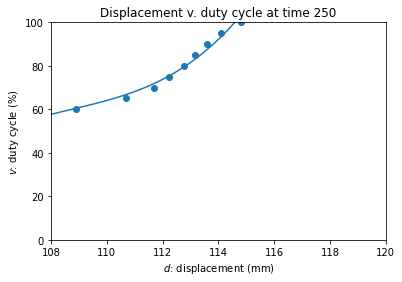

In [27]:
t = 250

plt.plot(*(polys[t].linspace()))

points = groups.get_group(t)
plt.scatter(points.d, points.v)
plt.xlim(left=108, right = 120)
plt.ylim(top=100, bottom=0)
plt.title("Displacement v. duty cycle at time {}".format(t))
plt.xlabel("$d$: displacement (mm)");
plt.ylabel("$v$: duty cycle (%)");

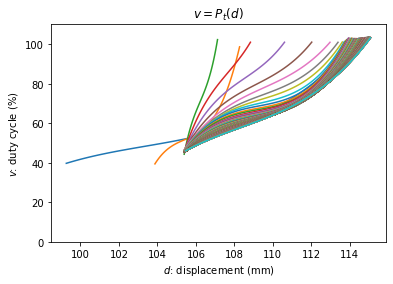

In [28]:
for poly, group in zip(polys, groups):
    plt.title("$v = P_t(d)$")
    plt.plot(*(poly.linspace()))
    plt.ylim(top=110, bottom=0)
    plt.xlabel("$d$: displacement (mm)")
    plt.ylabel("$v$: duty cycle (%)")

Let's try to replicate the experiment shown in the Singapore paper: Generate a sine wave, and see how well the elastomer can follow it with this polynomial approximation alone. We use a simple measuring framework, with one-to-one correspondence between target points and polynomials. Thus, each ploynomial is in a sense "single-use" -- it is only used for the exact timestemp for which it is calculated.

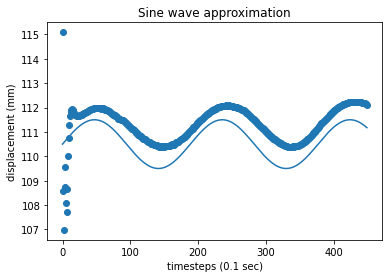

In [29]:
from scipy import signal

tester.dea.pwm(0)
center = 110.5

xs = []
ys = []
ds = []
ts = []

# Target.
def plot_sine_wave():
    sinx = np.arange(0, tester.intervals['hold'] / tester.intervals['sample'], 1)
    siny = 1 * np.sin(sinx / tester.intervals['hold'] * 1.5) + center
    plt.plot(sinx, siny)
    return sinx, siny
    
def plot_square_wave():
    sinx = np.linspace(0, tester.intervals['hold'] / tester.intervals['sample'], 300, endpoint=True)
    siny = signal.square(2 * np.pi * 2 * sinx) + center
    plt.plot(sinx, siny)
    return sinx, siny

def plot_triangle_wave():
    sinx = np.linspace(0, tester.intervals['hold'] / tester.intervals['sample'], 300, endpoint=True)
    siny = signal.triang(2 * np.pi * 2 * sinx) + center
    plt.plot(sinx, siny)
    return sinx, siny

sinx, siny = plot_sine_wave()

# Actual.
pwm = 0
i = 0
for y, poly in zip(siny, polys):
    duty = round(poly(y), 2)
    xs.append(y)
    ys.append(max(min(duty, 100), -100))
    print("center: {}, last displacement: {}, next displacement: {}; predicted duty cycle: {}".format(round(center, 2), ds[-1] if ds else center, round(y, 2), duty))
    tester.dea.pwm(duty)
    time.sleep(tester.intervals['sample'])
    ds.append(round(tester.sensor.distance(), 2))
    ts.append(i)
    i += 1
    clear_output(wait=True)
    
tester.dea.pwm(0)

plt.scatter(ts, ds);
plt.title("Sine wave approximation");
plt.xlabel("timesteps ({} sec)".format(tester.intervals['sample']));
plt.ylabel("displacement (mm)");

Let's also measure the voltage output over time.

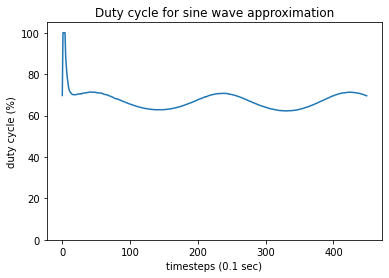

In [30]:
plt.plot(ts, ys);
plt.title("Duty cycle for sine wave approximation");
plt.xlabel("timesteps ({} sec)".format(tester.intervals['sample']));
plt.ylabel("duty cycle (%)");
plt.ylim(bottom=0, top=105);

In [32]:
rmse = np.sqrt(((siny - ys) ** 2).mean())
print("RMSE: {} mm".format(rmse.round(3)))

RMSE: 43.327 mm


Another interesting investigation is seeing how long it takes for the distance to change within a certain tolerance at a given duty cycle. This could also give valuable insight into hysteresis, and it could tell us how many polynomials we need for each duty cycle. We can use the power of Python here to customize the basic inner and outer loops that I have written.

## Deep $Q$-learning with experience replay

For ease of plugging in various engines, let's phrase this task as a Gym environment.

In [33]:
# TODO: Enable non-fixed episode length (for instance, we might want to break 
# when we are within a desired tolerance for certain timesteps)

import gym

class OneDimensionalDEA(gym.Env):
    def __init__(self, dea, ild, step, length):
        self.__version__ = "0.1.0"
        logging.info(f"1D DEA Control Env - Version {self.__version__}")
        
        # This is a scaling factor used for scaling PWM percentages.
        self.actions = [
            -1., -0.9, -9.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0,
            0.1, 0.2, -0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.
        ]
        
        # This is for real voltage values, not PWM.
        #self.actions = [
        #    0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0,
        #    -0.04, -0.08, -0.12, -0.18, -0.24, -0.28, -0.32, -0.36, -0.40
        #]
        #self.actions = [100 * action for action in self.actions]
        self.action_space = gym.spaces.Discrete(len(self.actions))
        
        self.dea = dea
        self.ild = ild
        
        # Observations: 0.25mm = 1 unit. 100mm -- 0; 120mm -- 80.
        self.scale = 0.05
        self.measure_start = 100
        self.measure_end = 120
        self.observation_space = gym.spaces.Discrete((self.measure_end -self. measure_start) // self.scale)
        
        self.timestep = step
        self.length = length
        self.time = 0
        self.episodes = 0
        self.done = False
        
    def bin_dist(self, distance):
        return max(min(round(distance, 4), self.measure_end), self.measure_start) // self.scale
        
    def step(self, action, target):
        if (self.time >= self.length):
            self.done = True
            
        self.time += 1
        self.dea.pwm(action)
        time.sleep(self.timestep)
        
        dist = self.bin_dist(self.ild.distance())
        return dist, -abs(dist - self.bin_dist(target)), self.done, {}
    
    def reset(self, t=10):
        self.time = 0
        self.episodes += 1
        self.done = False
        self.dea.pwm(0)
        
        if t > 0: time.sleep(t)
        return self.bin_dist(self.ild.distance())

The state of the system is defined as $$x_t = \{ t, d_t, v_{t-1}, y_{t+1}, y_{t+1+\tau}, y_{t+1+2\tau}, \hat v_t \}.$$ Variable $t$ is the current time, $v_{t-1}$ represents voltage at the previous timestep and target displacements governed by paramater $\tau$. Li et al. found a value of $\tau = 5$ gives the best performance. So using timesteps of 0.1 second, the agent can plan 1 second ahead.

I am following [this guide](https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9) for the layer code.

### I. Keras implementation

This implementation is based upon [`keon`'s model](https://gist.github.com/keon/b1286f826521b02a4abbf8750902153c).

In [34]:
import random
import pickle
import logging
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import RMSprop
from math import sqrt

We will attempt to replicate the work that the Signapore folks have done.

> In our RL control method, the $Q$-function $\mu(x)$ is parametrized by a multilayer perceptron (MLP). We use a two hidden-layer network with 50 units each. ReLU is used as hidden activations, and Batch Normalization is applied after each hiddden layer. A fully-connected layer followed by Softmax layer is added after the second hidden layer, which generates a probability distribution over possible actions. At each timestep, the action with the highest probability is taken.

In [35]:
# TODO: Update optimiser to use Signapore optimiser.

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        
        self.gamma = 0.9    # discount rate
        
        self.epsilon = 0.7  # exploration rate
        self.e_decay = 0.996
        self.e_min = 0.05
        
        self.learning_rate = 0.5
        self.learning_decay = 0.996
        self.learning_min = 0.0001
        
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(50, input_shape=(5, 1), activation='tanh'))
        model.add(Dense(50, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(50, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(self.action_size, activation='softmax'))
        model.compile(loss='mse', optimizer=RMSprop(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def import_memory(self, file):
        self.memory = pickle.load(open(file, "rb"))
        
    def export_memory(self):
        pickle.dump(self.memory, open("DQN-{}.p".format(time.strftime("%Y%m%d-%H%M%S")), "wb"))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        act_values = self.model.predict(state)
        #print(act_values)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][0][action] = reward
            else:
                target[0][0][action] = reward + self.gamma * \
                            np.max(self.model.predict(next_state)[0])
            
            self.model.fit(state, target, verbose=0)
            
        if self.epsilon > self.e_min:
            self.epsilon *= self.e_decay
            
        if self.learning_rate > self.learning_decay:
            self.learning_rate *= self.learning_decay

For a first test, we want to try tracing out a sine wave.

In [36]:
EPISODES = len(polys)
EPISODE_LENGTH = 450
TIME_STEP = 0.1
TAU = 5

REPLAY_MEMORY = 100

In [37]:
center = 110.5

def plot_sine_wave():
    xs = np.arange(0, EPISODE_LENGTH, 1)
    ys = 1 * np.sin(xs / 60 * 2) + center
    return xs, ys

Now, here is the main episode loop.

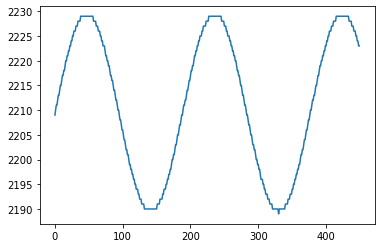

In [38]:
env = OneDimensionalDEA(dea, ild1320, TIME_STEP,  EPISODE_LENGTH)

state_size = env.observation_space.shape
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

prev_pwm = 0
tau_target = [0, 0]

xs, ys = plot_sine_wave()

plt.plot(xs, [env.bin_dist(y) for y in ys])
# plt.ylim(bottom=425, top=450);

In [39]:
try:
    episode_errors = np.empty(EPISODES)
    episode_errors_poly = np.empty(EPISODES)
    episode_rewards = np.empty(EPISODES)
    
    for e in range(EPISODES):
        # State: [current_displacement, prev_pwm, target_state, *tau_target]
        state = np.array( [env.reset(0), 0, 0, 0, 0] )
        action = 0
        
        input_xs = np.empty(EPISODE_LENGTH)
        input_ys = np.empty(EPISODE_LENGTH)
        actor_dists = np.empty(EPISODE_LENGTH)
        actor_rewards = np.empty(EPISODE_LENGTH)
        actor_pwms = np.empty(EPISODE_LENGTH)
        actor_pwms_poly = np.empty(EPISODE_LENGTH)
    
        for x, y, p in zip(xs, ys, polys):
            clear_output(wait=True)
            
            tau_target[0] = ys[min(x + TAU, ys.size - 1)]
            tau_target[1] = ys[min(x + 2 * TAU, ys.size - 1)]            
            target_state = np.array( [state[0], state[1], env.bin_dist(y), *tau_target] )

            poly_voltage = round(p(y), 2)
            
            dqn_out = agent.act(target_state)
            dqn_voltage = round(env.actions[dqn_out], 2)
            action = round(poly_voltage * dqn_voltage, 2)
            
            next_state, reward, done, _ = env.step(action, y)
            
            ## DATA COLLECTION ####
            print("episode: {}/{}, timestep: {}\{}: target: {}, command: <{}, {}> {}, actual: {}, reward: {}".format(
                e, EPISODES, x, EPISODE_LENGTH, env.bin_dist(y), poly_voltage, dqn_voltage, action, next_state, reward
            ))
            input_xs[x] = x
            input_ys[x] = env.bin_dist(y)
            actor_dists[x] = next_state
            actor_rewards[x] = reward
            actor_pwms[x] = action
            actor_pwms_poly[x] = poly_voltage
            ########################
        
            next_state = np.array( [next_state, dqn_out, env.bin_dist(y), *tau_target] )
            
            agent.remember(state, dqn_out, reward, next_state, done)
            state = next_state
            
            if done:
                break
        
        episode_errors[e] = sqrt(sum((actor_dists - input_ys) * (actor_dists - input_ys)) / EPISODE_LENGTH)
        episode_rewards[e] = sum(actor_rewards) / EPISODE_LENGTH
        print("episode: {}/{}, e: {:.2}, RMSE: {:.2}".format(e, EPISODES, agent.epsilon, episode_errors[e]))

        plt.scatter(input_xs, input_ys)
        plt.scatter(input_xs, actor_dists)
        plt.title("Sine wave approximation")
        plt.xlabel("timesteps ({} sec)".format(EPISODE_LENGTH * TIME_STEP))
        plt.ylabel("displacement ()")
        plt.show()
        env.reset()
            
        agent.replay(REPLAY_MEMORY)
except:
    env.dea.pwm(0)
    raise

KeyboardInterrupt: 

In [40]:
agent.export_memory()

We can compare the performance of the polynomials to the performance of our deep $Q$-learning implementation, which includes a small neural network. Note that this will only be for the most recent episode.

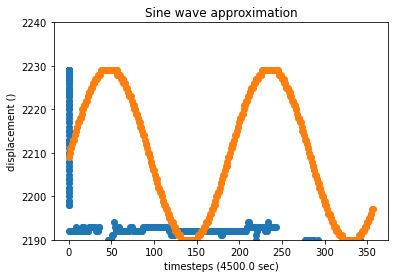

In [58]:
plt.scatter(input_xs, actor_dists)
plt.scatter(input_xs, input_ys)
plt.title("Sine wave approximation")
plt.xlabel("timesteps ({} sec)".format(EPISODE_LENGTH / TIME_STEP))
plt.ylabel("displacement ()")
plt.ylim(bottom=2190, top=2240);

Let's also compare RMSE for the polynomials and the neural network.

Text(0, 0.5, 'RMSE from actual to target')

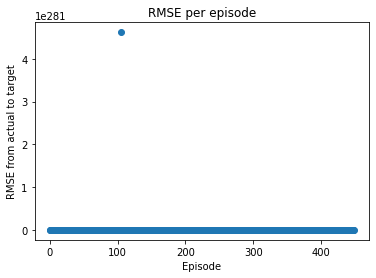

In [60]:
# TODO: Incorporate polynomials here (we will need to measure twice)

plt.scatter(range(EPISODES), episode_errors)
plt.title("RMSE per episode")
plt.xlabel("Episode")
plt.ylabel("RMSE from actual to target")

### II. Torch implementation (incomplete)

I will be using code from Chris Yoon's [excellent tutorial](https://towardsdatascience.com/dqn-part-1-vanilla-deep-q-networks-6eb4a00febfb).

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim[0], 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, self.output_dim)
        )

    def forward(self, state):
        qvals = self.fc(state)
        return qvals

First, we have a replay buffer, which allows us to track the environment's response across time, and we can then pick mini-batched to train the neural network that parameterizes the $Q$-function.

In [ ]:
class BasicBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)

    def __len__(self):
        return len(self.buffer)

In [ ]:
# TODO: Implement decaying learning rate, understand optimizer
# TODO: Implement epsilon-greedy

class DQNAgent:
    def __init__(self, env, learning_rate=0.01, gamma=0.99, buffer_size=10000):
        self.env = env
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.replay_buffer = BasicBuffer(max_size=buffer_size)
	
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(env.observation_space.shape, env.action_space.n).to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.MSE_loss = nn.MSELoss()

    def get_action(self, state, eps=0.20):
        state = torch.FloatTensor(state).float().unsqueeze(0).to(self.device)
        qvals = self.model.forward(state)
        action = np.argmax(qvals.cpu().detach().numpy())
        
        if(np.random.randn() < eps):
            return self.env.action_space.sample()

        return action

    def compute_loss(self, batch):
        states, actions, rewards, next_states, dones = batch
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones)

        curr_Q = self.model.forward(states).gather(1, actions.unsqueeze(1))
        curr_Q = curr_Q.squeeze(1)
        next_Q = self.model.forward(next_states)
        max_next_Q = torch.max(next_Q, 1)[0]
        expected_Q = rewards.squeeze(1) + self.gamma * max_next_Q

        loss = self.MSE_loss(curr_Q, expected_Q)
        return loss

    def update(self, batch_size):
        batch = self.replay_buffer.sample(batch_size)
        loss = self.compute_loss(batch)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
